# HW 9 - Tim Demetriades
## Machine Learning Classification with PySpark and MLlib
4/24/2021

**Team - Let's Go - Tim Demetriades and Alex Ibanez**

For this assignment, I (Tim) used the ratings.csv file without the genre scores, whereas Alex used the genre scores.

### Part 1 - Create ratings.csv
The file `ratings.csv` is the file that will be used by the ML classification models. It is a merging of 2 files:
- `output1.txt` - The file from Part 1 of HW 5 that has the columns `userID|trackID|albumScore|artistScore` It is 120,000 lines long.
- `test2_new.txt` - A file containing the ground truth for 6,000 user-track recommendations from `output1.txt`.

First we import the needed modules.

In [101]:
from pyspark.sql import SparkSession    # main entry point for DataFrame and SQL functionality
from pyspark.sql.functions import col    # for returning a column based on a given column name
from pyspark.sql.functions import lit    # for adding a new column to PySpark DataFrame
from pyspark.ml.classification import LogisticRegression    # for classification model
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler    # for preparing data for classification
from pyspark.ml.evaluation import MulticlassClassificationEvaluator    # for evaluating classification models
from pyspark.ml import Pipeline
import pandas as pd   # for data frames
import numpy as np    # for arrays
import time           # for timing cells  
import matplotlib.pyplot as plt # plotting graphs

Then we initialize SparkSession, the entry point to underlying Spark functionality in order to programmatically create Spark RDD, DataFrame and DataSet.

SparkSession contains the functionality of SparkContext, SQLContext, and more (starting with Spark 2.0).

In [2]:
spark = SparkSession.builder.appName('HW 9').getOrCreate()

We can use spark to get some data on it and get a link to the UI.

In [3]:
spark

We then create a Pandas DF for `test2_new.txt`

In [4]:
ground_truth_columns = ['userID', 'trackID', 'ground_truth']

In [5]:
ground_truth_df = pd.read_csv('test2_new.txt', sep='|', names=ground_truth_columns)

In [6]:
ground_truth_df

,userID,trackID,ground_truth
0,200031,30877,1
1,200031,8244,1
2,200031,130183,0
3,200031,198762,0
4,200031,34503,1
...,...,...,...
5995,212234,137371,0
5996,212234,42375,0
5997,212234,277867,1
5998,212234,83093,1


Next we create another Pandas DF for `output1.txt`.

In [7]:
scores_columns = ['userID', 'trackID', 'album_score', 'artist_score']

In [8]:
scores_df = pd.read_csv('output1.txt', sep='|', names=scores_columns)

In [9]:
scores_df

,userID,trackID,album_score,artist_score
0,199810,208019,0.0,0.0
1,199810,74139,0.0,0.0
2,199810,9903,0.0,0.0
3,199810,242681,0.0,0.0
4,199810,18515,0.0,70.0
...,...,...,...,...
119995,249010,72192,0.0,0.0
119996,249010,86104,0.0,0.0
119997,249010,186634,90.0,90.0
119998,249010,293818,0.0,0.0


Here we merge the 2 data frames with an inner join on the `userID` and `trackID` columns. This will give us a 6,000 line DF that contains the scores and ground truths.

In [10]:
ratings_df = ground_truth_df.merge(scores_df, on=['userID', 'trackID']).fillna(0)    # inner join by default

In [11]:
ratings_df

,userID,trackID,ground_truth,album_score,artist_score
0,200031,30877,1,90.0,50.0
1,200031,8244,1,90.0,0.0
2,200031,130183,0,0.0,0.0
3,200031,198762,0,0.0,0.0
4,200031,34503,1,90.0,50.0
...,...,...,...,...,...
5995,212234,137371,0,0.0,0.0
5996,212234,42375,0,0.0,0.0
5997,212234,277867,1,90.0,90.0
5998,212234,83093,1,90.0,90.0


Finally we write this to a csv file.

In [12]:
ratings_df.to_csv('ratings.csv', index=None)    # index=None means index column is not written to csv

### Part 2 - Classification Setup
Here is where we take `ratings.csv` and do some additional setup to prepare it for the different ML classification models.

First we create a Spark DF using `ratings.csv`. 

In [13]:
ratings_df = spark.read.csv('ratings.csv', header=True, inferSchema=True)    # inferSchema scans csv twice to get datatype of each column

In [14]:
ratings_df

DataFrame[userID: int, trackID: int, ground_truth: int, album_score: double, artist_score: double]

In [15]:
ratings_df.count()

6000

In [16]:
ratings_columns = ratings_df.columns

We can use `.groupby()` and `.count()` to see if the 2 classes (0 and 1) are balanced. We can see from the below that they are since each class has an equal number of entries.

In [17]:
pd.DataFrame(ratings_df.take(6000), columns=ratings_columns).groupby('ground_truth').count()

,userID,trackID,album_score,artist_score
ground_truth,,,,
0,3000,3000,3000,3000
1,3000,3000,3000,3000


Below is the schema of the Spark DF.

In [18]:
ratings_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: integer (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



We want the ground_truth column to be strings a not doubles so that we can use the `StringIndexer()` method on it.

In [22]:
ratings_df = ratings_df.withColumn('ground_truth', ratings_df['ground_truth'].cast('string'))

In [23]:
ratings_df.dtypes

[('userID', 'int'),
 ('trackID', 'int'),
 ('ground_truth', 'string'),
 ('album_score', 'double'),
 ('artist_score', 'double')]

Use `VectorAssembler()` to do a feature transform, merging mulitple numeric columns into a vector column

In [19]:
feature_columns = ['album_score', 'artist_score']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

Use `StringIndexer()` to encode a string column of labels to a column of label indices.

In [24]:
label_column = 'ground_truth'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

A Pipeline consists of a sequence of stages. We can use it to chain multiple Transformers and Estimators together to specifty our ML workflow.

An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer.

A Transformer is an algorithm which can transform one DataFrame into another DataFrame.

In [25]:
pipeline = Pipeline(stages=stages)               # initialize the pipeline
pipeline_model = pipeline.fit(ratings_df)        # fit the pipeline model
train_df = pipeline_model.transform(ratings_df)  # transform the input DF with the pipeline model

In [26]:
selected_columns = ['label', 'features'] + ratings_columns
train_df = train_df.select(selected_columns)
train_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: string (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



Above we can see that we now have 2 new columns:
- `label` - Column of type double that contains the labels
- `features` - Column of type vector that contains the features

Let's display the first 5 lines with a Pandas DF

In [27]:
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,0.0,0.0,1.0
features,"[90.0, 50.0]","[90.0, 0.0]","(0.0, 0.0)","(0.0, 0.0)","[90.0, 50.0]"
userID,200031,200031,200031,200031,200031
trackID,30877,8244,130183,198762,34503
ground_truth,1,1,0,0,1
album_score,90.0,90.0,0.0,0.0,90.0
artist_score,50.0,0.0,0.0,0.0,50.0


Now we split the data into training data and testing data with a 70:30 split.

In [28]:
train_df, test_df = train_df.randomSplit([0.7, 0.3], seed=2018)

In [29]:
print(f'Training Dataset Count: {train_df.count()}')
print(f'Test Dataset Count: {test_df.count()}')

Training Dataset Count: 4260
Test Dataset Count: 1740


--------------------------------------

#### Load in and prepare prediction file
Below, we load in the file `output1.txt`, which is the 120,000 long file we want to get predictions on with our models. We need to do a similar setup to what we did above by setting up the pipeline and getting the label and features columns.

In [113]:
prediction_df = spark.read.csv('output1.txt', sep='|', inferSchema=True)    # inferSchema scans csv twice to get datatype of each column

In [114]:
prediction_df.count()

120000

In [115]:
prediction_df = prediction_df.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "trackID").withColumnRenamed("_c2", "albumScore").withColumnRenamed("_c3", "artistScore")

In [116]:
prediction_columns = prediction_df.columns
prediction_columns

['userID', 'trackID', 'albumScore', 'artistScore']

In [117]:
prediction_df = prediction_df.withColumn('prediction', lit('0'))

In [118]:
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0.0,0.0,0.0,0.0,0.0
artistScore,0.0,0.0,0.0,0.0,70.0
prediction,0,0,0,0,0


In [119]:
prediction_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: double (nullable = true)
 |-- artistScore: double (nullable = true)
 |-- prediction: string (nullable = false)



In [120]:
feature_columns = ['albumScore', 'artistScore']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

In [121]:
label_column = 'prediction'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

In [122]:
prediction_pipeline = Pipeline(stages=stages)                       # initialize the pipeline
prediction_pipeline_model = prediction_pipeline.fit(prediction_df)  # fit the pipeline model
prediction_df = prediction_pipeline_model.transform(prediction_df)  # transform the input DF with the pipeline model

In [123]:
selected_columns = ['label', 'features'] + prediction_columns
prediction_df = prediction_df.select(selected_columns)
prediction_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: double (nullable = true)
 |-- artistScore: double (nullable = true)



In [124]:
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","[0.0, 70.0]"
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0.0,0.0,0.0,0.0,0.0
artistScore,0.0,0.0,0.0,0.0,70.0


### Model 1 - Logistic Regression

In [41]:
from pyspark.ml.classification import LogisticRegression

In [184]:
start_time = time.time()

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)  # initialize a logistic regression model
lr_model = lr.fit(train_df)                                                         # fit the training data with the model

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.63 seconds.


In [185]:
lr_model.coefficients

DenseVector([0.0452, 0.0326])

In [186]:
beta = np.sort(lr_model.coefficients)    # return a sorted copy of an array

In [187]:
beta

array([0.03256798, 0.04519993])

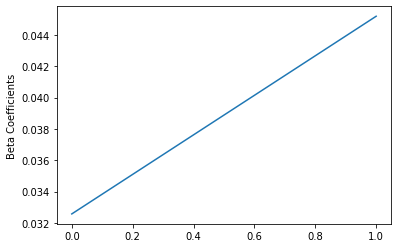

In [188]:
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [189]:
training_summary = lr_model.summary    # get summary (e.g. accuracy/precision/recall, objective history, total iterations) of model trained on the training set

In [190]:
roc = training_summary.roc.toPandas()    # get roc DF

In [191]:
roc

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.039683
2,0.000000,0.040149
3,0.000000,0.040616
4,0.000000,0.041083
...,...,...
88,0.076015,0.783847
89,0.076487,0.783847
90,0.076959,0.783847
91,1.000000,1.000000


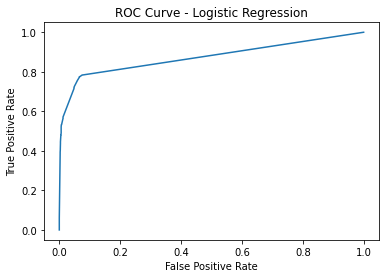

Training Set AUC = 0.8737133978552075


In [192]:
plt.plot(roc.FPR, roc.TPR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()
print(f'Training Set AUC = {training_summary.areaUnderROC}')

Above is the performance on the training dataset. An AUC of 0.874 is pretty solid. We now transform the test dataset with this model.

In [193]:
predictions = lr_model.transform(test_df)    # transform test_df with logistic regression model
predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200065| 179571|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200070| 124239|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200070| 271459|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200085| 134106|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200099|  41892|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200106| 152491|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200124| 284066|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200143| 131171|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200143| 187136|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200160| 231

In [194]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_predictions = predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200031|   8244|  1.0|[0.06488811545038...|[-2.6680016987576...|       1.0|
|200031|  30877|  1.0|[0.01343454147672...|[-4.2964005650945...|       1.0|
|200055|  56695|  1.0|[0.00368747275283...|[-5.5991196581640...|       1.0|
|200065| 179571|  0.0|[0.80218267023863...|[1.39999232241291...|       0.0|
|200065| 119451|  1.0|[0.17782905135233...|[-1.5311256369934...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



Probability column is where we can decide the 3 tracks with lowest 'probability' for `1` and 3 tracks with highest 'probabillity' for `0`.

Now that we have setup the logistic regression model, let's apply it to `prediction_df` which contains the 120,000 user-track combinations we want predictions for.

In [195]:
logistic_predictions = lr_model.transform(prediction_df)    # transform prediction_df with logistic regression model
logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80218267023863...|[1.39999232241291...|       0.0|
|199810|  74139|[0.80218267023863...|[1.39999232241291...|       0.0|
|199810|   9903|[0.80218267023863...|[1.39999232241291...|       0.0|
|199810| 242681|[0.80218267023863...|[1.39999232241291...|       0.0|
|199810|  18515|[0.29322625305511...|[-0.8797660904587...|       1.0|
|199810| 105760|[0.17782905135233...|[-1.5311256369934...|       1.0|
|199812| 276940|[0.80218267023863...|[1.39999232241291...|       0.0|
|199812| 142408|[0.00169767114648...|[-6.3767987671170...|       1.0|
|199812| 130023|[0.00169767114648...|[-6.3767987671170...|       1.0|
|199812|  29189|[0.80218267023863...|[1.39999232241291...|       0.0|
|199812| 223706|[0.13507584210861...|[-1.8568054102608...|       1.0|
|199812| 211361|[0.8

In [196]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_logistic_predictions = logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_logistic_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80218267023863...|[1.39999232241291...|       0.0|
|199810| 242681|[0.80218267023863...|[1.39999232241291...|       0.0|
|199810|  74139|[0.80218267023863...|[1.39999232241291...|       0.0|
|199810|   9903|[0.80218267023863...|[1.39999232241291...|       0.0|
|199810|  18515|[0.29322625305511...|[-0.8797660904587...|       1.0|
|199810| 105760|[0.17782905135233...|[-1.5311256369934...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [197]:
pd_sort_logistic_predictions = sort_logistic_predictions.toPandas().fillna(0.0)    # create a pandas df

In [198]:
pd_sort_logistic_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8021826702386359, 0.19781732976136412]","[1.3999923224129167, -1.3999923224129167]",0.0
1,199810,74139,"[0.8021826702386359, 0.19781732976136412]","[1.3999923224129167, -1.3999923224129167]",0.0
2,199810,9903,"[0.8021826702386359, 0.19781732976136412]","[1.3999923224129167, -1.3999923224129167]",0.0
3,199810,242681,"[0.8021826702386359, 0.19781732976136412]","[1.3999923224129167, -1.3999923224129167]",0.0
4,199810,18515,"[0.29322625305511973, 0.7067737469448803]","[-0.8797660904587368, 0.8797660904587368]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8021826702386359, 0.19781732976136412]","[1.3999923224129167, -1.3999923224129167]",0.0
119996,249010,293818,"[0.8021826702386359, 0.19781732976136412]","[1.3999923224129167, -1.3999923224129167]",0.0
119997,249010,110470,"[0.0036874727528380885, 0.9963125272471619]","[-5.599119658164091, 5.599119658164091]",1.0
119998,249010,186634,"[0.0036874727528380885, 0.9963125272471619]","[-5.599119658164091, 5.599119658164091]",1.0


In [199]:
columns_to_write = ['userID', 'trackID']
pd_sort_logistic_predictions.to_csv('lr_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [200]:
f_lr_predictions = open('lr_predictions.csv')                  
f_lr_final_predictions = open('lr_final_predictions.csv', 'w')

In [201]:
# Write header
f_lr_final_predictions.write('TrackID,Predictor\n')

18

In [202]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

Here is where we actually create the final predictions file for logistic regression.

In [203]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_lr_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list 
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track
    
    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i
        
    track_id_out_vec[i] = track_id_out          # add trackID to trackID array
        
    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID
    
    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions 
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):            
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)
        
        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_lr_final_predictions.write(out_str + '\n')

        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.36 seconds.


In [204]:
f_lr_predictions.close()
f_lr_final_predictions.close()

### Model 2 - Decision Tree Classifier

In [59]:
from pyspark.ml.classification import DecisionTreeClassifier

In [60]:
start_time = time.time()

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3)
dt_model = dt.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.82 seconds.


In [77]:
predictions_dt = dt_model.transform(test_df)

In [68]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_dt)    # evaluate decision tree model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [81]:
sort_predictions_dt = predictions_dt.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_dt.show(6)

+------+-------+-----+--------------------+--------------+----------+
|userID|trackID|label|         probability| rawPrediction|prediction|
+------+-------+-----+--------------------+--------------+----------+
|200031| 130183|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
|200031|  30877|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200031|   8244|  1.0|[0.01470588235294...|    [1.0,67.0]|       1.0|
|200055|  56695|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200065| 179571|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
|200065| 119451|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+-----+--------------------+--------------+----------+
only showing top 6 rows



Now that we have setup the decision tree model, let's apply it to `prediction_df` which contains the 120,000 user-track combinations we want predictions for.

In [144]:
dt_predictions = dt_model.transform(prediction_df)    # transform prediction_df with decision tree model
dt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 276940|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 142408|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 130023|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812|  29189|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 223706|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 211361|[0.80858085808580...|[1960.0,464.0]|       0.0|
+------+-------+--------------------+---

In [145]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_dt_predictions = dt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_dt_predictions.show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [146]:
pd_sort_dt_predictions = sort_dt_predictions.toPandas().fillna(0.0)    # create pandas df

In [147]:
pd_sort_dt_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
1,199810,74139,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
2,199810,9903,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
3,199810,242681,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
4,199810,18515,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119996,249010,293818,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119997,249010,110470,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
119998,249010,186634,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0


In [148]:
columns_to_write = ['userID', 'trackID']
pd_sort_dt_predictions.to_csv('dt_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without header)

In [149]:
f_dt_predictions = open('dt_predictions.csv')   
f_dt_final_predictions = open('dt_final_predictions.csv', 'w')

In [151]:
# Write header
f_dt_final_predictions.write('TrackID,Predictor\n')

18

In [152]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

Here is where we actually create the final predictions file for the decision tree model.

In [153]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_dt_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list 
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track
    
    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i
        
    track_id_out_vec[i] = track_id_out          # add trackID to trackID array
        
    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID
    
    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions 
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):            
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)
        
        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_dt_final_predictions.write(out_str + '\n')

        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.36 seconds.


In [154]:
f_dt_predictions.close()
f_dt_final_predictions.close()

### Model 3 - Random Forest Classifier

In [73]:
from pyspark.ml.classification import RandomForestClassifier

In [74]:
start_time = time.time()

rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_model = rf.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.79 seconds.


In [78]:
predictions_rf = rf_model.transform(test_df)

In [80]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_rf)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [82]:
sort_predictions_rf = predictions_rf.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_rf.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80799089778253...|[16.1598179556506...|       0.0|
|200031|  30877|  1.0|[0.01884857719121...|[0.37697154382428...|       1.0|
|200031|   8244|  1.0|[0.00563659951159...|[0.11273199023199...|       1.0|
|200055|  56695|  1.0|[0.01772239135707...|[0.35444782714158...|       1.0|
|200065| 179571|  0.0|[0.80799089778253...|[16.1598179556506...|       0.0|
|200065| 119451|  1.0|[0.17869186847180...|[3.57383736943609...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



Now that we have setup the random forest model, let's apply it to `prediction_df` which contains the 120,000 user-track combinations we want predictions for.

In [155]:
rf_predictions = dt_model.transform(prediction_df)    # transform prediction_df with random forest model
rf_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 276940|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 142408|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 130023|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812|  29189|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 223706|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 211361|[0.80858085808580...|[1960.0,464.0]|       0.0|
+------+-------+--------------------+---

In [156]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_rf_predictions = rf_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_rf_predictions.show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [166]:
pd_sort_rf_predictions = sort_rf_predictions.toPandas().fillna(0.0)    # create pandas df

In [167]:
pd_sort_rf_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
1,199810,74139,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
2,199810,9903,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
3,199810,242681,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
4,199810,18515,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119996,249010,293818,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119997,249010,110470,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
119998,249010,186634,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0


In [168]:
columns_to_write = ['userID', 'trackID']
pd_sort_rf_predictions.to_csv('rf_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [169]:
f_rf_predictions = open('rf_predictions.csv')   
f_rf_final_predictions = open('rf_final_predictions.csv', 'w')

In [170]:
# Write header
f_rf_final_predictions.write('TrackID,Predictor\n')

18

In [171]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

Here is where we actually create the final predictions file for the random forest model.

In [172]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_rf_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list 
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track
    
    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i
        
    track_id_out_vec[i] = track_id_out          # add trackID to trackID array
        
    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID
    
    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions 
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):            
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)
        
        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_rf_final_predictions.write(out_str + '\n')

        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.38 seconds.


In [173]:
f_dt_predictions.close()
f_dt_final_predictions.close()

### Model 4 - Gradient-Boosted Tree Classifier

In [83]:
from pyspark.ml.classification import GBTClassifier

In [205]:
start_time = time.time()

gbt = GBTClassifier(maxIter=100)
gbt_model = gbt.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 18.92 seconds.


In [206]:
predictions_gbt = gbt_model.transform(test_df)

In [207]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_gbt)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [208]:
sort_predictions_gbt = predictions_gbt.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_gbt.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
|200031|  30877|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200031|   8244|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200055|  56695|  1.0|[0.01632026531261...|[-2.0494463824457...|       1.0|
|200065| 179571|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
|200065| 119451|  1.0|[0.19777096337535...|[-0.7001422692047...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



Now that we have setup the gradient-boosted tree model, let's apply it to prediction_df which contains the 120,000 user-track combinations we want predictions for.

In [209]:
gbt_predictions = gbt_model.transform(prediction_df)    # transform prediction_df with gradient-boosted tree model
gbt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
|199810| 105760|[0.19777096337535...|[-0.7001422692047...|       1.0|
|199812| 276940|[0.80853359039673...|[0.72025491912707...|       0.0|
|199812| 142408|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812| 130023|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812|  29189|[0.80853359039673...|[0.72025491912707...|       0.0|
|199812| 223706|[0.12602709898363...|[-0.9682762071735...|       1.0|
|199812| 211361|[0.8

In [210]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_gbt_predictions = gbt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_gbt_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
|199810| 105760|[0.19777096337535...|[-0.7001422692047...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [211]:
pd_sort_gbt_predictions = sort_gbt_predictions.toPandas().fillna(0.0)    # create pandas df

In [212]:
pd_sort_gbt_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085335903967382, 0.19146640960326178]","[0.720254919127078, -0.720254919127078]",0.0
1,199810,74139,"[0.8085335903967382, 0.19146640960326178]","[0.720254919127078, -0.720254919127078]",0.0
2,199810,9903,"[0.8085335903967382, 0.19146640960326178]","[0.720254919127078, -0.720254919127078]",0.0
3,199810,242681,"[0.8085335903967382, 0.19146640960326178]","[0.720254919127078, -0.720254919127078]",0.0
4,199810,18515,"[0.24633418901301743, 0.7536658109869826]","[-0.5591299711568517, 0.5591299711568517]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085335903967382, 0.19146640960326178]","[0.720254919127078, -0.720254919127078]",0.0
119996,249010,293818,"[0.8085335903967382, 0.19146640960326178]","[0.720254919127078, -0.720254919127078]",0.0
119997,249010,110470,"[0.016320265312616513, 0.9836797346873835]","[-2.0494463824457223, 2.0494463824457223]",1.0
119998,249010,186634,"[0.016320265312616513, 0.9836797346873835]","[-2.0494463824457223, 2.0494463824457223]",1.0


In [213]:
columns_to_write = ['userID', 'trackID']
pd_sort_gbt_predictions.to_csv('gbt_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [214]:
f_gbt_predictions = open('gbt_predictions.csv')   
f_gbt_final_predictions = open('gbt_final_predictions.csv', 'w')

In [215]:
# Write header
f_gbt_final_predictions.write('TrackID,Predictor\n')

18

In [216]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

Here is where we actually create the final predictions file for the gradient-boosted tree model.

In [217]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_gbt_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list 
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track
    
    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i
        
    track_id_out_vec[i] = track_id_out          # add trackID to trackID array
        
    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID
    
    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions 
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):            
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)
        
        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_gbt_final_predictions.write(out_str + '\n')

        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.36 seconds.


In [218]:
f_gbt_predictions.close()
f_gbt_final_predictions.close()

### Analysis

Below is a table of the Kaggle Results for the 4 Machine Learning Classification Models.

|Logistic Regression|Decision Tree|Random Forest|Gradient-Boosted Tree|
|-------------------|-------------|-------------|---------------------|
|0.84494            |0.82444      |0.82444      |0.84499              |

As can be seen from the table, the **gradient-boosted tree** model seems to have performed the best, with the **logistic regression** model being a close second. Of course, tweaking some of the parameters when creating the models can cause this results to changes.

__Note__ - The above results are mine (Tim's). Alex (who included the genre scores and statistics in his features whereas my features only included album and artist scores) got a better result for logistic regression - **0.86749**.